In [2]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
# import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset, ConcatDataset
def datacsv2dl(img,cgm,viome,lbl):
    class dataset(Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            d = torch.tensor(self.data.iloc[idx][self.data.columns.difference(['Subject ID','Day'])])
            label = torch.tensor(self.labels.iloc[idx][self.labels.difference(['Subject ID','Day'])], dtype=torch.int32)
            return d, label
    
    img_data = pd.read_csv(img)
    img_data['Image Before Breakfast'] = img_data['Image Before Breakfast'].apply(ast.literal_eval).apply(np.array)
    img_data['Image Before Lunch'] = img_data['Image Before Lunch'].apply(ast.literal_eval).apply(np.array)

    cgm_data = pd.read_csv(cgm)
    cgm_data['Breakfast Time'] = pd.to_datetime(cgm_data['Breakfast Time'], errors='coerce')
    cgm_data['Lunch Time'] = pd.to_datetime(cgm_data['Lunch Time'], errors='coerce')
    cgm_data['CGM Data'] = cgm_data['CGM Data'].apply(ast.literal_eval)
    for _, row in cgm_data.iterrows():
        for i, t in enumerate(row['CGM Data']):
            row['CGM Data'][i] = (datetime.strptime(t[0], '%Y-%m-%d %H:%M:%S').timestamp(), t[1:])

    viome_data = pd.read_csv(viome)
    viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)

    data = img_data.merge(cgm_data, on=['Subject ID','Day'])
    data = data.merge(viome_data, on=['Subject ID'])

    labels = pd.read_csv(lbl)
    if lbl[-8:]=='only.csv':
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Breakfast Carbs','Breakfast Fat','Breakfast Protein']]
    else:
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']]
    
    ds = dataset(data,labels)
    return DataLoader(ds, batch_size=32, shuffle=True)

def HM(dt):
    return dt.hour * 60 + dt.minute

def datacsv2ndarry_cgm(cgm,viome,lbl):
    # img_data = pd.read_csv(img)
    # img_data['Image Before Breakfast'] = img_data['Image Before Breakfast'].apply(ast.literal_eval).apply(np.array)
    # img_data['Image Before Lunch'] = img_data['Image Before Lunch'].apply(ast.literal_eval).apply(np.array)

    cgm_data = pd.read_csv(cgm)
    cgm_data['Breakfast Time'] = pd.to_datetime(cgm_data['Breakfast Time'], errors='coerce').apply(HM)
    cgm_data['Lunch Time'] = pd.to_datetime(cgm_data['Lunch Time'], errors='coerce').apply(HM)
    cgm_data['CGM Data'] = cgm_data['CGM Data'].apply(ast.literal_eval)
    cgm_data.dropna(subset=['Breakfast Time','Lunch Time','CGM Data'],inplace=True)
    for j, row in cgm_data.iterrows():
        if cgm_data.at[j, 'CGM Data']==[]:
            cgm_data.drop(j, inplace=True)
            continue
        # print(j)
        # try:
        # cgm_data.at[j, 'Breakfast Time'] = HM(row['Breakfast Time'])
        # cgm_data.at[j, 'Lunch Time'] = HM(row['Lunch Time'])
        for i, t in enumerate(row['CGM Data']):
            row['CGM Data'][i] = [HM(datetime.strptime(t[0], '%Y-%m-%d %H:%M:%S')), t[1]]
        # except:
        #     cgm_data.drop(j, inplace=True)

    viome_data = pd.read_csv(viome)
    # viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)

    data = cgm_data.merge(viome_data, on=['Subject ID'])

    labels = pd.read_csv(lbl)
    if lbl[-8:]=='only.csv':
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Breakfast Carbs','Breakfast Fat','Breakfast Protein']]
        labels = labels[['Breakfast Calories','Breakfast Carbs']]
        print(f'Label Columns: {labels.columns}')
    else:
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']]
        labels = labels[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs']]
        print(f'Label Columns: {labels.columns}')
    data = data[['Breakfast Time','Lunch Time','CGM Data','Diabetes Status','A1C']]
    print(f'Data Columns: {data.columns}')
    
    return np.array(data), np.array(labels)

In [3]:
# train_loader = datacsv2dl('data/img_train.csv','data/cgm_train.csv','data/demo_viome_train.csv','data/label_train.csv')
# test_loader = datacsv2dl('data/img_test.csv','data/cgm_test.csv','data/demo_viome_test.csv','data/label_test_breakfast_only.csv')

print('Training Set:')
X,Y = datacsv2ndarry_cgm('../data/cgm_train.csv','../data/demo_viome_train.csv','../data/label_train.csv')
print('\nTesting Set:')
Xt,Yt = datacsv2ndarry_cgm('../data/cgm_test.csv','../data/demo_viome_test.csv','../data/label_test_breakfast_only.csv')

from sklearn.model_selection import train_test_split
X,Xv,Y,Yv = train_test_split(X,Y,train_size=0.8,random_state=143)

Training Set:
Label Columns: Index(['Breakfast Calories', 'Lunch Calories', 'Breakfast Carbs',
       'Lunch Carbs'],
      dtype='object')
Data Columns: Index(['Breakfast Time', 'Lunch Time', 'CGM Data', 'Diabetes Status', 'A1C'], dtype='object')

Testing Set:
Label Columns: Index(['Breakfast Calories', 'Breakfast Carbs'], dtype='object')
Data Columns: Index(['Breakfast Time', 'Lunch Time', 'CGM Data', 'Diabetes Status', 'A1C'], dtype='object')


In [4]:
X.shape, Xv.shape, Y.shape, Yv.shape

((224, 5), (56, 5), (224, 4), (56, 4))

In [5]:
X

array([[458.0, 722.0,
        list([[460, 138.55333333333334], [465, 153.19333333333333], [470, 172.46666666666667], [475, 193.28666666666666], [480, 217.38], [485, 243.56], [490, 263.73333333333335], [495, 271.0], [500, 270.7266666666667], [505, 267.81333333333333], [510, 258.44666666666666], [515, 246.81333333333333], [520, 239.08666666666667], [525, 231.81333333333333], [530, 223.81333333333333], [535, 216.90666666666667], [540, 214.54666666666665], [545, 217.36666666666667], [550, 222.09333333333333], [555, 225.82], [560, 228.82], [565, 234.00666666666666], [570, 245.28], [575, 256.46], [580, 264.3666666666667], [585, 269.3666666666667], [590, 273.5466666666667], [595, 274.7266666666667], [600, 274.2733333333333], [605, 275.0], [610, 273.9066666666667], [615, 269.6333333333333], [620, 262.72], [625, 249.9], [630, 236.54], [635, 228.63333333333333], [640, 225.27333333333334], [645, 224.36], [650, 217.26666666666668], [655, 206.99333333333334], [660, 197.08666666666667], [665, 190.36

In [6]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.target = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        if not row[2]:
            raise ValueError(f"Sequence at index {idx} is empty.")
        seq = torch.tensor(row[2], dtype=torch.float32)
        aux = torch.tensor([row[0], row[1], row[3], row[4]], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return seq, aux, target

# Collate function for DataLoader
def collate_fn(batch):
    sequences, aux_data, targets = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    aux_data = torch.stack(aux_data)
    targets = torch.stack(targets)
    return padded_sequences, lengths, aux_data, targets


dataset = TimeSeriesDataset(X,Y)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn)
dataloader_v = DataLoader(TimeSeriesDataset(Xv,Yv), batch_size=32, collate_fn=collate_fn)

In [7]:
dataloader.dataset.data.shape, dataloader.dataset.target.shape
# dataloader.dataset.data

((224, 5), (224, 4))

In [8]:
class RNNWithAuxiliary(nn.Module):
    def __init__(self, input_dim, hidden_dim, aux_dim, output_dim):
        super(RNNWithAuxiliary, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.aux_dense = nn.Linear(aux_dim, 16)
        
        # Fully connected layers for the combined output
        self.fc1 = nn.Linear(hidden_dim + 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, sequences, lengths, aux_data):
        # Pack sequences for LSTM
        packed_sequences = pack_padded_sequence(sequences, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_sequences)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        lstm_output = hidden[-1]  # Take the last hidden state

        # Process auxiliary data
        aux_output = torch.relu(self.aux_dense(aux_data))

        # Concatenate LSTM output and auxiliary data
        combined = torch.cat((lstm_output, aux_output), dim=1)

        # Pass through fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)
        return output


In [9]:
# Initialize Model
input_dim = 2  # Each time step has 2 features
hidden_dim = 32
aux_dim = 4  # Auxiliary features
output_dim = 4  # Single output
model = RNNWithAuxiliary(input_dim, hidden_dim, aux_dim, output_dim)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training_loss = []
validation_loss = []

# Training Loop
for epoch in range(20):
    model.train()
    for sequences, lengths, aux_data, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences, lengths, aux_data)
        train_loss = criterion(outputs.squeeze(), targets)
        train_loss.backward()
        optimizer.step()
    
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():  # Disable gradient computation
        for sequences, lengths, aux_data, targets in dataloader_v:
            # Forward pass
            outputs = model(sequences, lengths, aux_data)
            eval_loss = criterion(outputs.squeeze(), targets)
            
            # Accumulate loss and sample count
            total_loss += eval_loss.item() * len(targets)
            total_samples += len(targets)
    # Compute average loss
    avg_loss = total_loss / total_samples

    training_loss.append(train_loss.item())
    validation_loss.append(avg_loss)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item():.4f}, Evaluation Loss: {avg_loss:.4f}")

Epoch 1, Training Loss: 202755.8906, Evaluation Loss: 177769.8415
Epoch 2, Training Loss: 191912.8281, Evaluation Loss: 167620.9621
Epoch 3, Training Loss: 178014.9219, Evaluation Loss: 154307.7254
Epoch 4, Training Loss: 159052.7188, Evaluation Loss: 136447.3147
Epoch 5, Training Loss: 133893.4062, Evaluation Loss: 113097.7042
Epoch 6, Training Loss: 102366.8281, Evaluation Loss: 84633.8047
Epoch 7, Training Loss: 67409.8672, Evaluation Loss: 54853.5513
Epoch 8, Training Loss: 38866.6914, Evaluation Loss: 34333.7907
Epoch 9, Training Loss: 29753.6465, Evaluation Loss: 32911.9314
Epoch 10, Training Loss: 31106.3945, Evaluation Loss: 34780.5251
Epoch 11, Training Loss: 28867.6973, Evaluation Loss: 30385.6501
Epoch 12, Training Loss: 28667.2305, Evaluation Loss: 28372.6936
Epoch 13, Training Loss: 29280.6777, Evaluation Loss: 28131.5446
Epoch 14, Training Loss: 29002.6484, Evaluation Loss: 28188.1763
Epoch 15, Training Loss: 28607.8652, Evaluation Loss: 28560.1166
Epoch 16, Training Loss

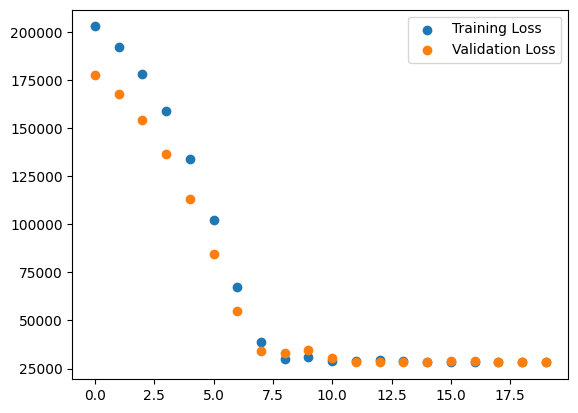

In [10]:
plt.scatter(range(20), training_loss, label='Training Loss')
plt.scatter(range(20), validation_loss, label='Validation Loss')
plt.legend()
plt.show()

In [12]:
# Initialize Model
input_dim = 2  # Each time step has 2 features
hidden_dim = 32
aux_dim = 4  # Auxiliary features
output_dim = 4  # Single output
model = RNNWithAuxiliary(input_dim, hidden_dim, aux_dim, output_dim)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloader = DataLoader(ConcatDataset([TimeSeriesDataset(X,Y),TimeSeriesDataset(Xv,Yv)]), batch_size=32, collate_fn=collate_fn)
dataloader_t = DataLoader(TimeSeriesDataset(Xt,Yt), batch_size=32, collate_fn=collate_fn)
# Training Loop
for epoch in range(15):
    model.train()
    for sequences, lengths, aux_data, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences, lengths, aux_data)
        train_loss = criterion(outputs.squeeze(), targets)
        train_loss.backward()
        optimizer.step()

from sklearn.metrics import r2_score
# Evaluation
model.eval()
total_loss = 0.0
total_samples = 0
rmse = 0.0
all_targets = []
all_outputs = []
with torch.no_grad():  # Disable gradient computation
    for sequences, lengths, aux_data, targets in dataloader_v:
        # Forward pass
        outputs = model(sequences, lengths, aux_data)
        eval_loss = criterion(outputs.squeeze(), targets)
        
        # Accumulate loss and sample count
        total_loss += eval_loss.item() * len(targets)
        total_samples += len(targets)
        rmse += torch.sqrt(train_loss) * len(targets)

        # Store outputs and targets for R² calculation
        all_outputs.append(outputs.squeeze().cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Compute average loss
avg_loss = total_loss / total_samples
avg_rmse = rmse / total_samples

# Convert lists of arrays to flattened arrays
all_outputs = np.concatenate([output.flatten() for output in all_outputs], axis=0)
all_targets = np.concatenate([target.flatten() for target in all_targets], axis=0)
# Compute R2 score
r2 = r2_score(all_targets, all_outputs)

print(f"Avg Loss: {avg_loss:.4f}, Avg RMSE: {avg_rmse:.4f}, R² Score: {r2:.4f}")

Avg Loss: 30028.3823, Avg RMSE: 186.4251, R² Score: 0.6657


In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():  # Disable gradient computation
    for sequences, lengths, aux_data, targets in dataloader:
        # Forward pass
        outputs = model(sequences, lengths, aux_data)
        
        # Store predictions and targets
        # predictions.append(outputs.cpu().numpy())
        for row in outputs:
            predictions.append(row.numpy())

df = pd.Series(predictions, name=None).to_csv('predictions.csv', index=False, header=False)